# Code

## To record 
- 30 fps : 6 left and 4 right
- 60 fps : 10 left and 10 right

## OBS
- Let's see the model results with 30 fps videos and if needed record more with 60 fps.
- Video names explained:
    - rf: right feet
    - lf: left feet
    - s : special
- Data split: train (80%), valid (10%), test (10%)

## Data transformations:
- Cut the raw videos to 20 ms each - which produces 20 images with 30 fps.
- Get the same amount of no and yes for each video
- Consider yes when:  
    - starts when support foot is fully supported on the floor
    - ends before kicking the ball


### Dependencies
- pip install torch==2.0.0+cu118 torchvision==0.15.1+cu118 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu118
- pip install ultralytics ipykernel moviepy

Check cuda

In [ ]:
import torch
torch.cuda.is_available()

## Converting videos to images

In [ ]:
# trocando o diretório atual
import os
path = '/home/rafaa/pmy/penalty_project'
os.chdir(path)
print(os.getcwd())

In [12]:
import subprocess,os,glob
from IPython.display import Video
from moviepy.editor import *

def get_file_extension_from_filepath(filepath): return filepath.split('.')[-1]
def get_filename_from_filepath(filepath): return filepath.split('/')[-1].split('.')[0]

def get_video_fps(filepath):
    # Get the original frame rate using ffprobe
    ffprobe_cmd = [
        "ffprobe",
        "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "stream=r_frame_rate",
        "-of", "default=noprint_wrappers=1:nokey=1",
        filepath
    ]
    # Run ffprobe to get the frame rate
    result = subprocess.run(ffprobe_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    original_fps = result.stdout.strip()
    return original_fps

def convert_video_to_images(filepath, paths):
    filename = get_filename_from_filepath(filepath)
    original_fps = get_video_fps(filepath)
    # original_fps=60
    folder = f"{paths['images']}/{filename}"
    os.makedirs(folder,exist_ok=True)
    output_image_pattern = f"{folder}/{filename}_%04d.jpg"  # Adjust output pattern as needed

    # Define FFmpeg command to convert MXF to images
    ffmpeg_cmd = [
        "ffmpeg",
        "-y",               # Automatically overwrite output files
        "-i", filepath,
        "-vf", f"fps={original_fps}",  # Set output frame rate
        '-q:v', '0',             # Output quality (0 - 31, 2 is a good default)
        '-qmin', '1',            # Minimum quantization value
        '-qmax', '31',           # Maximum quantization value
        output_image_pattern
    ]

    subprocess.run(ffmpeg_cmd, check=True)
    print("Conversion complete")

# set folders and create them if needed
data_path =  f'data'
paths = {
    'videos':f'{data_path}/videos',
    'images':f'{data_path}/images',
    }
for p in paths.values(): os.makedirs(p,exist_ok=True)
videos = glob.glob(f"{paths['videos']}/*")
# for video in videos:
#     print(get_video_fps(video))
#     # convert_video_to_images(video, paths) # debug

video='data/videos/rf0.mp4'
convert_video_to_images(video, paths)

ffmpeg version 4.3.6-0+deb11u1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 

Conversion complete


frame=   20 fps=0.0 q=0.0 Lsize=N/A time=00:00:00.66 bitrate=N/A speed=2.21x    
video:13155kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown


## Análise
 Após analisar imagem por imagem, tagea-se as images da seguinte forma:
- yes, se a imagem corresponde ao momento imediatamente anterior ao chute
- no, caso contrário 

Além disso, a partir dos 14 videos, e seguindo a proporção de 
- 80%(treino) = 12 videos
- 10%(validação) = 1 video ok
- 10%(teste) = 1 video 

#### Lista de comandos para dividir as imagens nos diretórios 
listar os positivos antes de mover
```
for i in $(seq -f "%04g" 80 88); do ls "data/images/IMG_5360/IMG_5360_$i.jpg"; done
```

mover os positivos   
```
for i in $(seq -f "%04g" 80 88); do mv "data/images/IMG_5360/IMG_5360_$i.jpg" "data/dataset/train/yes/"; done
```

mover os negativos
```
mv data/images/IMG_5360/* data/dataset/train/no/
```

remover a pasta
```
rm -r data/images/IMG_5360
```



## Plotando os frames de um video

Video (sec): 0-0.67
Frames: 0-20


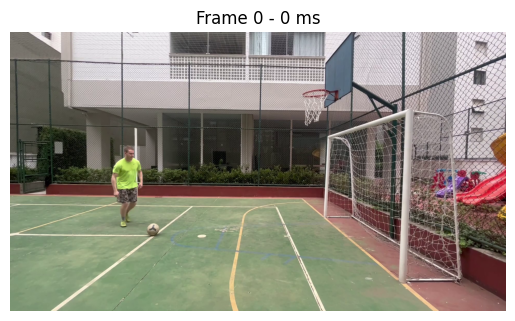

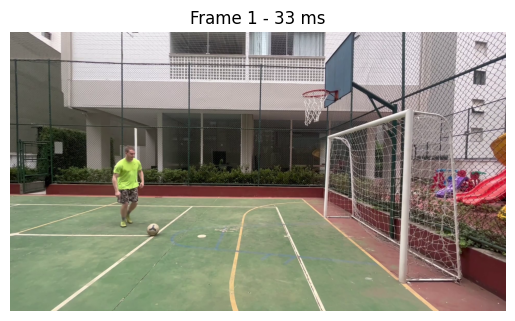

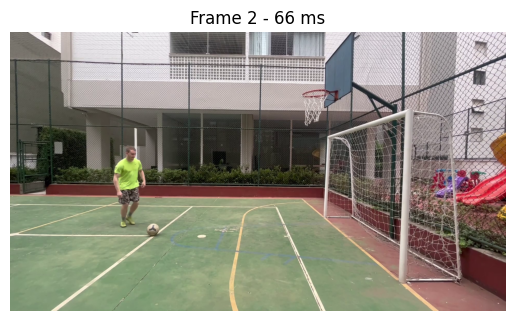

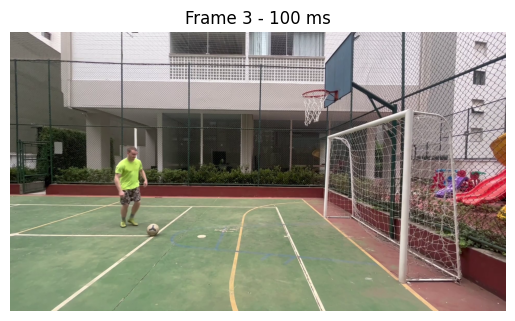

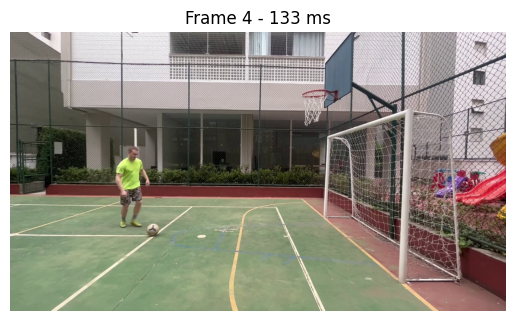

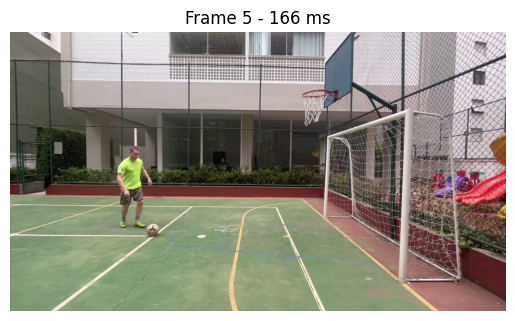

In [13]:
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt

DEBUG = 1
video='data/videos/rf0.mp4'
cap = cv.VideoCapture(video)

# Check if the video file is opened successfully
if not cap.isOpened(): 
    print("Error: Could not open video file.")
    # return
    print('error') 

# Get the video codec and properties from the input video 
fps = int(cap.get(cv.CAP_PROP_FPS))
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

total_duration = frame_count / fps 
print(f"Video (sec): {0}-{round(total_duration,2)}")
print(f"Frames: {0}-{frame_count}")

q=0
frame_number=0
q_max = 5
cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
while(True):
    ret, frame = cap.read()
    if not ret:
        print(f"Error reading frame {frame_number}")
        break
    
    # Get the timestamp (time in ms) of the frame
    frame_time = int(cap.get(cv.CAP_PROP_POS_MSEC))

    # plot the predicted image
    im = Image.fromarray(frame[..., ::-1])  # RGB PIL image
        
    # show img
    plt.imshow(im)
    plt.title(f"Frame {frame_number} - {round(frame_time,5)} ms")
    plt.axis('off')
    plt.show()
        
    if(q == q_max): break
    frame_number+=1
    q+=1

cap.release()

Video (sec): 0-7.24
Frames: 0-210


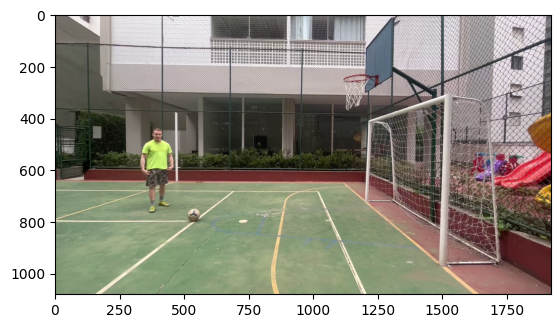

In [15]:
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt

DEBUG = 1
cap = cv.VideoCapture(video)

if not cap.isOpened(): 
    print("Error: Could not open video file.")
    print('error') 

# Get the video codec and properties from the input video 
fps = int(cap.get(cv.CAP_PROP_FPS))
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

total_duration = frame_count / fps 
print(f"Video (sec): {0}-{round(total_duration,2)}")
print(f"Frames: {0}-{frame_count}")

frame_number=200
cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()
plt.axis('off')
plt.imshow(im)

# while(True):
#     ret, frame = cap.read()
#     if not ret:
#         print(f"Error reading frame {frame_number}")
#         break
    
#     # Get the timestamp (time in ms) of the frame
#     frame_time = int(cap.get(cv.CAP_PROP_POS_MSEC))

#     # plot the predicted image
#     im = Image.fromarray(frame[..., ::-1])  # RGB PIL image
#     plt.imshow(im)
#     plt.title(f"Frame {frame_number} - {round(frame_time,5)} ms")
#     plt.axis('off')
#     plt.show()
        
#     if(DEBUG & (frame_number == 5)): break
#     frame_number+=1

cap.release()

## Treinando o modelo YOLO V8
editar o arquivo de configurações, de acordo com os valores abaixo:
```
# /home/rafaa/.config/Ultralytics/settings.yaml
datasets_dir: /home/rafaa/pmy/penalty_project/data
weights_dir: /home/rafaa/pmy/penalty_project/data/weights
runs_dir: /home/rafaa/pmy/penalty_project/data/runs
```

In [ ]:
from IPython.display import display
from PIL import Image
from ultralytics import YOLO
import os

# change current folder
print(os.getcwd())
if 'data' not in os.getcwd():
    os.makedirs('data/dataset',exist_ok=True) # criar diretorio
    os.chdir('data')
print(os.getcwd())

Realizando o treinamento com GPU

In [ ]:
model = YOLO('yolov8n-cls.pt')
results = model.train(
    data='dataset',
    epochs=100,
    imgsz=640,
    verbose=True,
    device=0)

# Inferindo

## Imagem

In [ ]:
from IPython.display import display
from PIL import Image
from ultralytics import YOLO
import os

# change current folder
os.chdir('/home/rafaa/pmy/penalty_project/data')
best_model_path = '/home/rafaa/pmy/penalty_project/data/runs/classify/train/weights/best.pt'
path = "/home/rafaa/pmy/penalty_project/data/images/IMG_5369/IMG_5369_0010.jpg"

# Load the model
model = YOLO(best_model_path)

# inference
r = model(path,save=False, conf=0.15, iou=0.1,device='0')[0]

# Show the results
im_array = r.plot(conf=True)  # plot a BGR numpy array of predictions
im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
display(im)

# Tratando o resultado
classes_names = r.names
probs = r.cpu().probs.data.tolist()
classes_probs = {}
for k,v in classes_names.items(): classes_probs[v] = round(probs[k],2)
print("Results : ", classes_probs)


## frames de um Video

In [ ]:
from IPython.display import display
from PIL import Image
from ultralytics import YOLO
import os
import cv2 as cv
import matplotlib.pyplot as plt

path,frame_start,frame_end = 'videos/IMG_5361.MOV',70,100 # test 
path,frame_start,frame_end = 'videos/IMG_5358.MOV',44,50 # valid

# change current folder
os.chdir('/home/rafaa/pmy/penalty_project/data')
best_model_path = 'runs/classify/train/weights/best.pt'

# Load the model
model = YOLO(best_model_path)
DEBUG = 1
count = 0
cap = cv.VideoCapture(path)

# Check if the video file is opened successfully
if not cap.isOpened(): 
    print("Error: Could not open video file.")
    # return
    print('error') 

# Get the video codec and properties from the input video 
fps = int(cap.get(cv.CAP_PROP_FPS))
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
total_duration = frame_count / fps 
print(f"Video (sec): {0}-{round(total_duration,2)}")
print(f"Frames: {0}-{frame_count}")

frame_number=0
cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
while(True):
    ret, frame = cap.read()
    if not ret:
        print(f"Error reading frame {frame_number}")
        break

    frame_ = frame.copy()
    # Get the timestamp (time in ms) of the frame
    frame_time = int(cap.get(cv.CAP_PROP_POS_MSEC))
    frame_number+=1

    if (frame_number < frame_start or frame_number > frame_end) : continue

    count+=1
    # inference
    r = model(frame,save=False, conf=0.01, iou=0.1,device='0',verbose=False)[0]

    classes_names = r.names
    probs = r.cpu().probs.data.tolist()
    classes_probs = {}
    for k,v in classes_names.items(): classes_probs[v] = round(probs[k],2)

    # Define the position and size of the rectangle
    top_left_corner = (0, 0)
    bottom_right_corner = (width, 100)
    rectangle_color = (255, 255, 255)  # White color in BGR
    rectangle_thickness = -1  # Filled rectangle

    # Draw the white rectangle
    cv.rectangle(frame, top_left_corner, bottom_right_corner, rectangle_color, rectangle_thickness)

    # Write text on the frame using OpenCV before converting it to RGB
    font = cv.FONT_HERSHEY_SIMPLEX
    classes_probs_text = f"No ({classes_probs['no']*100.0}%) - Yes ({classes_probs['yes']*100.0}%)" 
    text = f"Frame {frame_number}/{frame_count} - Time {round(frame_time,5)} ms - {classes_probs_text}"
    position = (50, 70)
    font_scale = 1.5
    font_color = (0, 0, 0)
    line_type = 2

    # Calculate text size
    (text_width, text_height), _ = cv.getTextSize(text, font, font_scale, line_type)

    # Calculate the center position
    text_x = (width - text_width) // 2
    text_y = top_left_corner[1] + ((bottom_right_corner[1] - top_left_corner[1]) + text_height) // 2

    # The position where the text will start
    position = (text_x, text_y)

    # Put the text on the frame
    cv.putText(frame, text, position, font, font_scale, font_color, line_type)
    frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

    # save
    cv.imwrite(f'{frame_number}.jpg', frame)

    plt.figure(figsize=(10, 5))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()

    if(DEBUG == 1 and count == 1): break

cap.release()

In [ ]:
frame = frame_.copy()

# Define the position and size of the rectangle
top_left_corner = (0, 0)
bottom_right_corner = (width, 100)
rectangle_color = (255, 255, 255)  # White color in BGR
rectangle_thickness = -1  # Filled rectangle

# Draw the white rectangle
cv.rectangle(frame, top_left_corner, bottom_right_corner, rectangle_color, rectangle_thickness)

# Write text on the frame using OpenCV before converting it to RGB
font = cv.FONT_HERSHEY_SIMPLEX
classes_probs_text = f"No ({classes_probs['no']*100.0}%) - Yes ({classes_probs['yes']*100.0}%)" 
text = f"Frame {frame_number}/{frame_count} - Time {round(frame_time,5)} ms - {classes_probs_text}"
position = (50, 70)
font_scale = 1.5
font_color = (0, 0, 0)
line_type = 2

# Calculate text size
(text_width, text_height), _ = cv.getTextSize(text, font, font_scale, line_type)

# Calculate the center position
text_x = (width - text_width) // 2
text_y = top_left_corner[1] + ((bottom_right_corner[1] - top_left_corner[1]) + text_height) // 2

# The position where the text will start
position = (text_x, text_y)

# Put the text on the frame
cv.putText(frame, text, position, font, font_scale, font_color, line_type)
frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

cv.imwrite('image.png', frame)

plt.imshow(frame_rgb)
plt.axis('off')
plt.show()